In [1]:
import requests
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from scipy.stats import pearsonr
from fastdtw import fastdtw


# Retrieve alpha vantage api_key
with open('config.json', 'r') as config_file:
            config_data = json.load(config_file)
            api_key =  config_data.get('alpha_vantage_api_key')

# Motivation
On the 23-08-2023 nvidia dropped its results. So we fetch the data from the 21.08 to the 25.08. On this specific case we then can examine wether there is a relation between public sentiment and stock price. In the next steps we will fetch the nvidia stock price data for that period, normalize both data and then compare these two time series. 

### First step: Fetch sentiment data

In [2]:
# Fetch most 50 relevant public sentiment data of articles where nvidia is mentioned on 21.08
url = (
    f'https://www.alphavantage.co/query?function=NEWS_SENTIMENT&tickers=NVDA&apikey={api_key}'
    '&limit=50&sort=relevance&time_from=20230821T0000&time_to=20230821T2359'
    )
r = requests.get(url)
data = r.json()
nvidia_sentiment_data21_df = pd.DataFrame(data['feed'])

In [3]:
# Fetch most 50 relevant public sentiment data of articles where nvidia is mentioned on 22.08
url = (
    f'https://www.alphavantage.co/query?function=NEWS_SENTIMENT&tickers=NVDA&apikey={api_key}'
    '&limit=20&sort=relevance&time_from=20230822T0000&time_to=20230822T2359'
    )
r = requests.get(url)
data = r.json()
nvidia_sentiment_data22_df = pd.DataFrame(data['feed'])

In [4]:
# Fetch most 50 relevant public sentiment data of articles where nvidia is mentioned on 23.08
url = (
    f'https://www.alphavantage.co/query?function=NEWS_SENTIMENT&tickers=NVDA&apikey={api_key}'
    '&limit=50&sort=relevance&time_from=20230823T0000&time_to=20230823T2359'
    )
r = requests.get(url)
data = r.json()
nvidia_sentiment_data23_df = pd.DataFrame(data['feed'])

In [5]:
# Fetch most 50 relevant public sentiment data of articles where nvidia is mentioned on 24.08
url = (
    f'https://www.alphavantage.co/query?function=NEWS_SENTIMENT&tickers=NVDA&apikey={api_key}'
    '&limit=50&sort=relevance&time_from=20230824T0000&time_to=20230824T2359'
    )
r = requests.get(url)
data = r.json()
nvidia_sentiment_data24_df = pd.DataFrame(data['feed'])

In [6]:
# Fetch most 50 relevant public sentiment data of articles where nvidia is mentioned on 25.08
url = (
    f'https://www.alphavantage.co/query?function=NEWS_SENTIMENT&tickers=NVDA&apikey={api_key}'
    '&limit=50&sort=relevance&time_from=20230825T0000&time_to=20230825T2359'
    )
r = requests.get(url)
data = r.json()
nvidia_sentiment_data25_df = pd.DataFrame(data['feed'])

In [7]:
# Combine all the data to one single pd dataframe
combined_nvidia_sentiment_data_df = pd.concat([nvidia_sentiment_data21_df, nvidia_sentiment_data22_df,
                                                nvidia_sentiment_data23_df, nvidia_sentiment_data24_df,
                                                  nvidia_sentiment_data25_df], axis=0)

In [8]:
# Add a column 'Date' with type datetime to the dataframe
combined_nvidia_sentiment_data_df['Date'] = pd.to_datetime(combined_nvidia_sentiment_data_df['time_published'])
# Sort the values by the 'Date' column
combined_nvidia_sentiment_data_df = combined_nvidia_sentiment_data_df.sort_values(by='Date', ascending=True)
# Set the 'Date' column as index
combined_nvidia_sentiment_data_df.set_index('Date', inplace=True)

In [9]:
# Create a dataframe with just one column left. The ticker_sentiment_score of nvidia for each article
nvidia_ticker_sentiment_df = combined_nvidia_sentiment_data_df['ticker_sentiment'].apply(lambda x: next(
    (item['ticker_sentiment_score'] for item in x if item['ticker'] == 'NVDA'), None))
# Convert the panda series to a dataframe
nvidia_ticker_sentiment_df = nvidia_ticker_sentiment_df.to_frame()

# Convert 'ticker_sentiment' to numeric. 'coerce' will convert non-numeric values to NaN
nvidia_ticker_sentiment_df['ticker_sentiment'] = pd.to_numeric(nvidia_ticker_sentiment_df['ticker_sentiment'],
                                                                errors='coerce')

In [10]:
# Normalize the data with min() max() normalization
nvidia_normalized_sentiment_df = (nvidia_ticker_sentiment_df-nvidia_ticker_sentiment_df.
             min())/(nvidia_ticker_sentiment_df.max()-nvidia_ticker_sentiment_df.min())

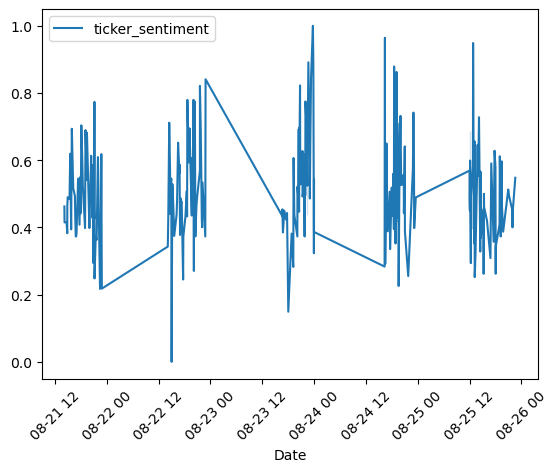

In [12]:
# Plot the sentiment data
sns.lineplot(data=nvidia_normalized_sentiment_df)
# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)
# Show the plot
plt.show()

### Now we fetch the nvidia intraday stock price data for the 2023-08

In [13]:
url = (
    f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol=NVDA&interval=5min&apikey={api_key}'
    '&outputsize=full&month=2023-08'
    )   
r = requests.get(url)
data = r.json()
# Extract 'Time Series (5min)' object
nvidia_intraday_df = pd.DataFrame(data['Time Series (5min)'])
# Transpose the dataframe structure
nvidia_intraday_df = nvidia_intraday_df.T

In [14]:
# Now we want to extract the data for the period 21 - 26
start_date = '2023-08-21'
end_date = '2023-08-26'

# Use boolean indexing to filter the DataFrame
new_nvidia_intraday_df = nvidia_intraday_df[(nvidia_intraday_df.index >= start_date) &
                                             (nvidia_intraday_df.index <= end_date)]

In [15]:
# Create a new dataframe with just one column, '4. close'.
new_nvidia_intraday_df = pd.DataFrame(new_nvidia_intraday_df['4. close'])
new_nvidia_intraday_df['4. close'] = pd.to_numeric(new_nvidia_intraday_df['4. close'], errors='coerce')

In [16]:
# Change order of entries
new_nvidia_intraday_df = new_nvidia_intraday_df[::-1]
# Normalize this dataframe 
nvidia_normalized_intraday_df = (new_nvidia_intraday_df-new_nvidia_intraday_df.
               min())/(new_nvidia_intraday_df.max()-new_nvidia_intraday_df.min())


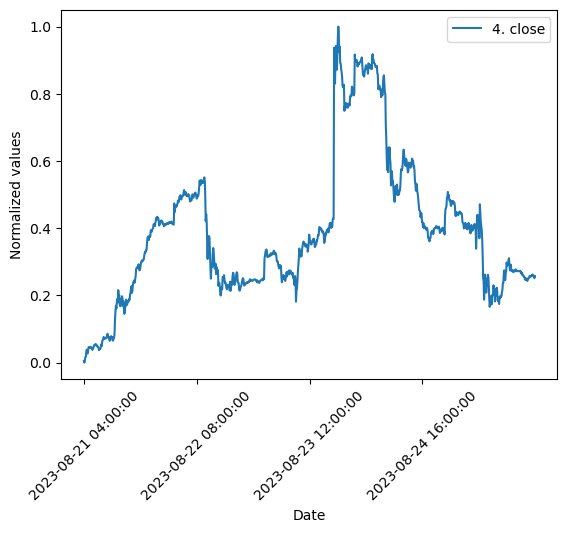

In [20]:
# Determine the number of dates you want to display (e.g., 5)
num_dates_to_display = 5

# Calculate the step size to evenly sample the dates
step = max(len(nvidia_normalized_intraday_df) // (num_dates_to_display - 1), 1)

# Get the index (dates) at the selected intervals
x_dates = nvidia_normalized_intraday_df.index[::step]

sns.lineplot(data=nvidia_normalized_intraday_df)
plt.xticks(x_dates, rotation=45)
plt.xlabel('Date')
plt.ylabel('Normalized values')
plt.show()

### Combine sentiment and intraday dataset to compare both in one plot

In [52]:
# Concatenate them vertically (stack them on top of each other)
final_df = pd.concat([nvidia_normalized_intraday_df, nvidia_normalized_sentiment_df], axis=0)

# Sort the DataFrame by 'datetime_column' in ascending order
final_df.reset_index(inplace=True)
final_df['Date'] = pd.to_datetime(final_df['index'])
final_df = final_df.sort_values(by='Date')

# Get the original structe back
final_df = final_df.drop('index', axis=1)
final_df = final_df.set_index('Date')

In [53]:
# There are a lot of NaN values in this dataframe yet. So we need to fill them
final_df = final_df.fillna(method="ffill")
final_df = final_df.fillna(method="bfill")

<Axes: xlabel='Date'>

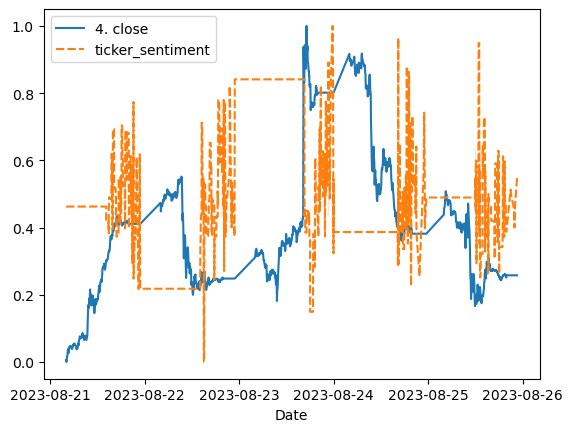

In [54]:
# Plot the data
sns.lineplot(data=final_df)

## Now smooth both traces

In [80]:
# Adjust the window size as needed
window_size = 30  
smoothed_final_df = final_df
smoothed_final_df['4. close_smoothed'] = smoothed_final_df['4. close'].rolling(window=window_size).mean()
smoothed_final_df['ticker_sentiment_smoothed'] = smoothed_final_df['ticker_sentiment'].rolling(window=window_size).mean()
# Drop rows with NaN values created by the rolling mean calculation
smoothed_final_df.dropna(inplace=True)

In [81]:
# Delete old traces
smoothed_final_df = smoothed_final_df.drop('4. close', axis=1)
smoothed_final_df = smoothed_final_df.drop('ticker_sentiment', axis=1)

<Axes: xlabel='Date'>

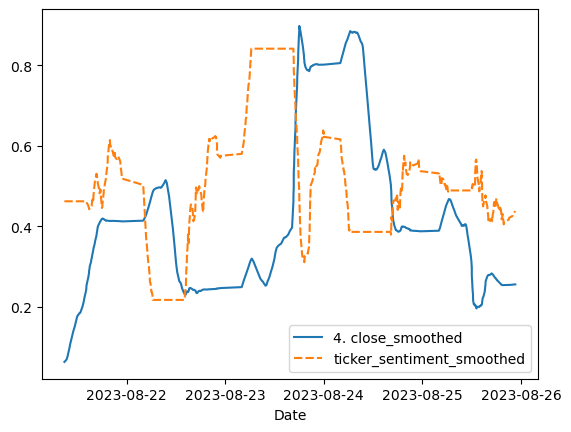

In [82]:
sns.lineplot(data=smoothed_final_df)

Now create a plot with shifted ticker_sentiment to see how similar these two traces are

In [84]:
# Identify and handle duplicate datetime index values by aggregating them
smoothed_final_df = smoothed_final_df.groupby(level=0).mean()

# Ensure the index is sorted in ascending order
smoothed_final_df = smoothed_final_df.sort_index()

In [85]:
# Shift the "ticker_sentiment_smoothed" column by 8 hours
smoothed_final_df['ticker_sentiment_smoothed_shifted'] = smoothed_final_df['ticker_sentiment_smoothed'].shift(freq='15H')
# Fill NaN values with 0
smoothed_final_df = smoothed_final_df.fillna(method="bfill")
smoothed_final_df = smoothed_final_df.fillna(method="ffill")

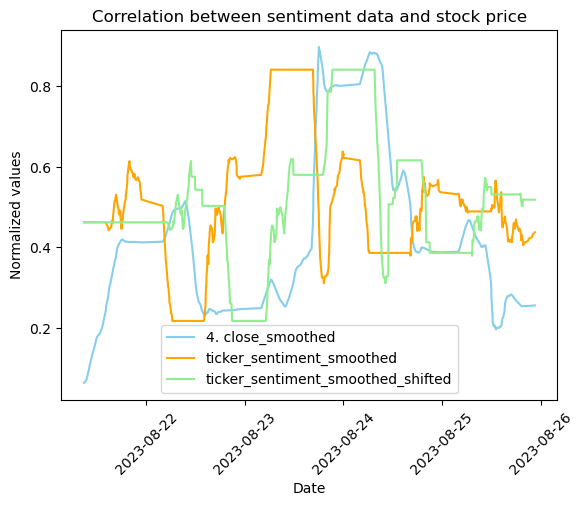

In [86]:
lighter_orange = (1.0, 0.7, 0.0)
sns.lineplot(data=smoothed_final_df, palette=["skyblue", "orange", "lightgreen"], dashes=False)
# Add a legend with custom labels
plt.title("Correlation between sentiment data and stock price")
plt.ylabel('Normalized values')
plt.xticks(rotation=45)
plt.show()

### Now compare the two time series with dynamic time warping method, Eucledian Distance and Correlation Coefficient

In [75]:
# Extract the two time series as NumPy arrays
time_series_1 = smoothed_final_df['4. close_smoothed'].values
time_series_2 = smoothed_final_df['ticker_sentiment_smoothed_shifted'].values
time_series_3 = smoothed_final_df['ticker_sentiment_smoothed'].values
time_series_4 = np.array([2, 3, 4, 5, 6]) # test time series

In [74]:
# Eucledian distance
# Calculate the Euclidean distance between the two time series
euclidean_distance = np.linalg.norm(time_series_1 - time_series_2)

print("Euclidean Distance:", euclidean_distance)

Euclidean Distance: 7.1024289779997485


In [77]:
# Perform Dynamic Time Warping
distance, path = fastdtw(time_series_1, time_series_2)

# Print the DTW distance (similarity measure) and the alignment path
print(f"DTW Distance: {distance}")
print(f"Alignment Path: {path}")

DTW Distance: 106.47049165544801
Alignment Path: [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 31), (32, 32), (33, 33), (34, 34), (35, 35), (36, 36), (37, 37), (38, 38), (39, 39), (40, 40), (41, 41), (42, 42), (43, 43), (44, 44), (45, 45), (46, 46), (47, 47), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77), (78, 78), (79, 79), (80, 80), (81, 81), (82, 82), (83, 83), (84, 84), (85, 85), (86, 86), (87, 87), (88, 88), (89, 89), (90, 90), (91, 91), (92, 92), (93, 93), (94, 94), (95, 95), (96, 96), 

A DTW distance of 90 using FastDTW suggests a relatively low dissimilarity between the two time series.

In [79]:
# Calculate the Pearson correlation coefficient
pearson_correlation, _ = pearsonr(time_series_1, time_series_2)

# Print the Pearson correlation coefficient
print(f"Pearson Correlation Coefficient: {pearson_correlation}")

Pearson Correlation Coefficient: 0.5401100954568121
